In [395]:

import sys
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import os
from glob import glob
import pandas as pd
from scipy.integrate import simps,cumtrapz

import matplotlib.pyplot as plt

import functools
#import warnings

import numpy as np
import george
from george.modeling import Model

from george import kernels

import emcee

import corner
import scipy.optimize as op

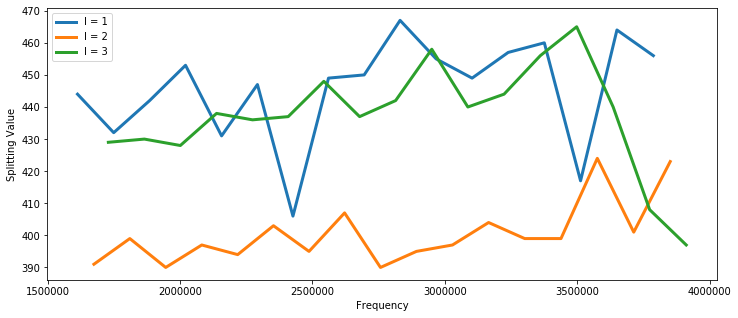

In [396]:
x_small = pd.read_table('x')
x_small = np.array(x_small)
flatx = x_small.flatten()


frequ = pd.read_table('freq.dat', sep='\s+')



# Load stuff once.
def load_kernels(dirname="kerns/", size=4800):
    paths = glob(dirname + "/l.*_n.*")
    max_l = 1 + max([int(path.split(".")[1].split("_")[0]) for path in paths])
    max_n = 1 + max([int(path.split(".")[-1]) for path in paths])

    kerns = np.nan * np.ones((max_l, max_n, size))

    for l in range(1 + max_l):
        for n in range(1 + max_n):
            path = os.path.join(dirname, "l.{l:.0f}_n.{n:.0f}".format(l=l, n=n))
            if not os.path.exists(path): continue
            kerns[l, n, :] = np.loadtxt(path, skiprows=1)

    return kerns

beta = np.loadtxt("beta.dat", skiprows=1) # l, n, beta
kerns = load_kernels()


freqnu = frequ.loc[frequ['n'] > 9]
freqnl = freqnu.loc[freqnu['n'] < 27]


freqs_1 = np.array(freqnl.loc[freqnl['l'] == 1]['Freqs'])*1E3
freqs_2 = np.array(freqnl.loc[freqnl['l'] == 2]['Freqs'])*1E3
freqs_3 = np.array(freqnl.loc[freqnl['l'] == 3]['Freqs'])*1E3


lone = np.ones((np.shape(freqs_1)[0],2))
ltwo = 2*np.ones((np.shape(freqs_2)[0],2))
lthree = 3*np.ones((np.shape(freqs_3)[0],2))

lone[:,0] = freqs_1
ltwo[:,0] = freqs_2
lthree[:,0] = freqs_3

xvals = np.append(lone,ltwo,axis = 0)
xvals = np.append(xvals,lthree,axis = 0)

freqs = np.array([freqs_1,freqs_2,freqs_3])

split_vals_1 = np.array(freqnl.loc[freqnl['l'] == 1]['delta'])
split_vals_2 = np.array(freqnl.loc[freqnl['l'] == 2]['delta'])
split_vals_3 = np.array(freqnl.loc[freqnl['l'] == 3]['delta'])


split_vals_plot = np.array([split_vals_1,split_vals_2,split_vals_3])

split_vals = np.append(split_vals_1,split_vals_2)
split_vals = np.append(split_vals, split_vals_3)



e_split_vals_1 = np.array(freqnl.loc[freqnl['l'] == 1]['e_delta'])
e_split_vals_2 = np.array(freqnl.loc[freqnl['l'] == 2]['e_delta'])
e_split_vals_3 = np.array(freqnl.loc[freqnl['l'] == 3]['e_delta'])

e_split_vals = np.append(e_split_vals_1,e_split_vals_2)
e_split_vals = np.append(e_split_vals, e_split_vals_3)


fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(freqs_1, split_vals_1, lw=3, label="l = 1");
ax.plot(freqs_2, split_vals_2, lw=3, label="l = 2");
ax.plot(freqs_3, split_vals_3, lw=3, label="l = 3");

ax.set_xlabel("Frequency"); ax.set_ylabel("Splitting Value"); plt.legend();
plt.show()

In [397]:
modelS = pd.read_table('modelS.dat', sep='\\s+')
# acoustic depth: tau(r) = int_r^R 1/c(x) dx (Aerts et al. eqn. 3.228)
cs = np.sqrt(modelS['c2'].values)
r  = modelS['r'].values
tau = np.hstack((0, -cumtrapz(1./cs, r)))

x_diffs = np.zeros_like(flatx)
for j in range(1,len(flatx)):
    x_diffs[j] = flatx[j] - flatx[j-1]

In [398]:
def splittings(omega, l):
    vals = []
    for n in freqnl.loc[freqnl['l']==l]['n']: # 0 to 35?
        area = np.dot(
            x_diffs,
            omega * kerns[l, n, :]
        )
        beta_mask = (beta[:, 0] == l) * (beta[:, 1] == n)
        delta = beta[beta_mask, 2] * area
    
        vals.append(delta[0])
    vals = np.array(vals)
#    if (l == 1):
#        vals = vals
#    else if (l == 2):
#        vals = 1.5*vals
#    else:
#        vals = 2*vals
    return vals

class Model(Model):
    parameter_names = ("a", "b","c","d")

    def get_value(self, t):
        rot_prof = self.a * np.arctan(flatx*self.b-self.c)+self.d
        vals = np.append(splittings(rot_prof,1),splittings(rot_prof,2))
        vals = np.append(vals,splittings(rot_prof,3))
        return vals

    def get_value_plot(self, t):
        rot_prof = self.a * np.arctan(flatx*self.b-self.c)+self.d
        vals = np.array([splittings(rot_prof,1),splittings(rot_prof,2),splittings(rot_prof,3)])
        return vals

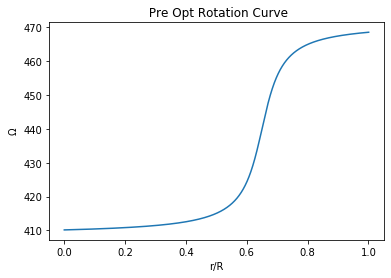

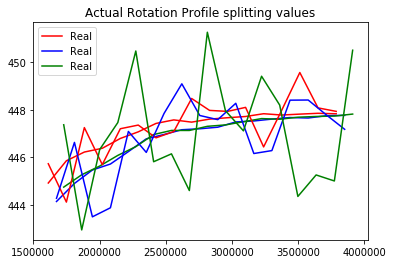

In [399]:
truth = dict(a=-20, b=-20, c=-13,  d= 440)#log_sigma=np.log(0.4))

kwargs = dict(**truth)
#kwargs["bounds"] = dict(a=(-0,50),b = (-50,-15),c = (-20,-10),d = (200,500))
#kwargs["bounds"] = dict(a=(-5,5), b = (0,15),c = (0,10.))
mean_model = Model(**kwargs)

plt.figure()
ao,bo,co,do = mean_model.get_parameter_vector()
plt.plot(flatx,ao * np.arctan(flatx*bo-co)+do)
plt.title(' Pre Opt Rotation Curve')
plt.xlabel('r/R')
plt.ylabel(r'$\Omega$')
#plt.ylim(0,500)
plt.show()

plt.figure()
actual_rot = ao * np.arctan(flatx*bo-co)+do

actual_1 = splittings(actual_rot,1)
actual_2 = splittings(actual_rot,2)
actual_3 = splittings(actual_rot,3)


plt.plot(freqs_1,actual_1, color = 'red')
plt.plot(freqs_2,actual_2, color = 'blue')
plt.plot(freqs_3,actual_3, color = 'green')

split_1_unc = 1 * np.ones(len(freqs_1))
split_2_unc = 2 * np.ones(len(freqs_2))
split_3_unc = 3 * np.ones(len(freqs_3))

split_obs_1 = actual_1 + np.random.randn(len(freqs_1)) * split_1_unc
split_obs_2 = actual_2 + np.random.randn(len(freqs_2)) * split_2_unc
split_obs_3 = actual_3 + np.random.randn(len(freqs_3)) * split_3_unc


plt.plot(freqs[0],split_obs_1,label = 'Real', color = 'red')
#plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'First Guess', color = 'red', linestyle = '-.')
plt.plot(freqs[1],split_obs_2,label = 'Real', color = 'blue')
#plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'First Guess',color = 'red', linestyle = '-.')
plt.plot(freqs[2],split_obs_3,label = 'Real', color = 'green')
#plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'First Guess', color = 'green', linestyle = '-.')
plt.legend(loc = 'best')
plt.title('Actual Rotation Profile splitting values')

plt.show()

In [400]:
split_vals = np.append(split_obs_1,split_obs_2)
split_vals = np.append(split_vals, split_obs_3)
e_split_vals = np.append(split_1_unc,split_2_unc)
e_split_vals = np.append(e_split_vals, split_3_unc)

In [401]:
split_vals.shape

(51,)

In [402]:
gp = george.GP(1 * kernels.ExpSquaredKernel(metric=1e-3 * np.eye(2), ndim=2, metric_bounds=[(-10, 15), (None, None), (-10, 10)]), mean = mean_model, fit_mean=True, fit_white_noise=True)

#gp = george.GP(1 * kernels.ExpSquaredKernel(metric=1e-5 * np.eye(2), ndim=2, metric_bounds=[(-10, 10), (None, None), (-6, -2.3)]))


gp.set_parameter('kernel:k2:metric:L_0_1',0)
gp.freeze_parameter('kernel:k2:metric:L_0_1')

#this is the part where im confused
#gp.compute(flatx)



gp.compute(xvals, e_split_vals)

def log_prior(p):
#    a, b, c,d,k1_log_constant, k2_M_0, k2_M_1 = p
#    #k1_log_constant, k2_M_0, k2_M_1 = p
#
##    if not (15 >= b >= 0):
##        return -np.inf
#    if not all(i > 0 for i in (a * np.arctan(flatx*b-c)+d)):
#        return -np.inf
    return 0


def log_prob(p):
    gp.set_parameter_vector(p)
    return log_prior(p) \
        +   gp.log_prior() + gp.log_likelihood(split_vals, quiet=True)

def negative_log_prob(p):
    return -log_prob(p)
    

def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(split_vals, quiet=True)



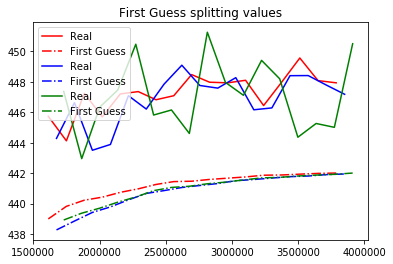

In [403]:
#guess = dict(a=-30, b=-25, c=-11,  d= 450)#log_sigma=np.log(0.4))
guess = dict(a=-15, b=-22, c=-10,  d= 430)
kwargs = dict(**guess)
kwargs["bounds"] = dict(a=(-60,-10),b = (-30,-10),c = (-50,0),d = (200,500))
#kwargs["bounds"] = dict(a=(-5,5), b = (0,15),c = (0,10.))
mean_model = Model(**kwargs)


#take a plot of initial guess
plt.figure()

plt.plot(freqs[0],split_obs_1,label = 'Real', color = 'red')
plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'First Guess', color = 'red', linestyle = '-.')
plt.plot(freqs[1],split_obs_2,label = 'Real', color = 'blue')
plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'First Guess',color = 'blue', linestyle = '-.')
plt.plot(freqs[2],split_obs_3,label = 'Real', color = 'green')
plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'First Guess', color = 'green', linestyle = '-.')
plt.legend(loc = 'best')
plt.title('First Guess splitting values')
plt.show()

-15.0 -22.0 -10.0 430.0
-95.85613313277574
-95.85613313277032
-91.09587174887942
-90.56399472501765
-90.1550301005749
-17.329076532029397 -190.50769533924523 -127.0324307833283 440.9497462920018


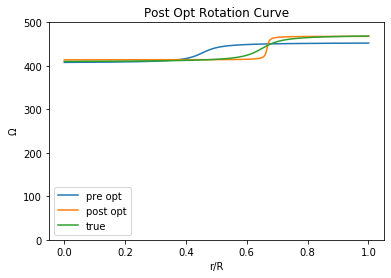

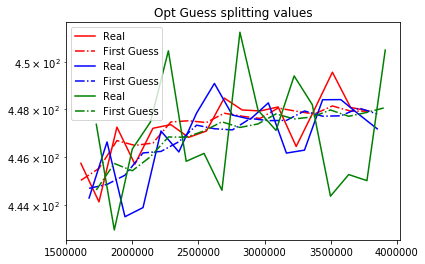

In [404]:

plt.figure()

ao,bo,co,do = mean_model.get_parameter_vector()
print(ao,bo,co,do)
plt.plot(flatx,ao * np.arctan(flatx*bo-co)+do, label = 'pre opt')

print(gp.log_likelihood(split_vals))

gp.freeze_all_parameters()
gp.thaw_parameter('white_noise:value')
p0 = gp.get_parameter_vector()
results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
print(gp.log_likelihood(split_vals))

gp.set_parameter_vector(results.x)
mean_model.set_parameter_vector(results.x[0:4])

gp.thaw_all_parameters()
gp.freeze_parameter('kernel:k2:metric:L_0_1')
gp.freeze_parameter('mean:b')
gp.freeze_parameter('mean:c')
p0 = gp.get_parameter_vector()
results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
print(gp.log_likelihood(split_vals))
gp.set_parameter_vector(results.x)
mean_model.set_parameter_vector(results.x[0:4])

gp.thaw_all_parameters()
gp.freeze_parameter('kernel:k2:metric:L_0_1')
# gp.freeze_parameter('mean:d')

# p0 = gp.get_parameter_vector()
# results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
# gp.set_parameter_vector(results.x)

# gp.set_parameter_vector(results.x)

# gp.thaw_all_parameters()
# gp.freeze_parameter('kernel:k2:metric:L_0_1')
# gp.freeze_parameter('mean:a')

# p0 = gp.get_parameter_vector()
# results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
# gp.set_parameter_vector(results.x)

gp.freeze_parameter('mean:a')
gp.freeze_parameter('mean:d')
p0 = gp.get_parameter_vector()
results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
print(gp.log_likelihood(split_vals))

gp.set_parameter_vector(results.x)
mean_model.set_parameter_vector(results.x[0:4])

gp.thaw_all_parameters()
gp.freeze_parameter('kernel:k2:metric:L_0_1')


p0 = gp.get_parameter_vector()
results = op.minimize(negative_log_prob, p0, method = 'Nelder-Mead', options = dict(maxiter=2000))
gp.set_parameter_vector(results.x)
mean_model.set_parameter_vector(results.x[0:4])


print(gp.log_likelihood(split_vals))



ao,bo,co,do = mean_model.get_parameter_vector()
print(ao,bo,co,do)
plt.plot(flatx,ao * np.arctan(flatx*bo-co)+do, label = 'post opt')
plt.plot(flatx,actual_rot,label = 'true')
plt.title('Post Opt Rotation Curve')
plt.xlabel('r/R')
plt.ylabel(r'$\Omega$')
plt.ylim(0,500)
plt.legend(loc = 'best')
plt.show()

#take a plot of initial guess
plt.figure()

plt.plot(freqs[0],split_obs_1,label = 'Real', color = 'red')
plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'First Guess', color = 'red', linestyle = '-.')
plt.plot(freqs[1],split_obs_2,label = 'Real', color = 'blue')
plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'First Guess',color = 'blue', linestyle = '-.')
plt.plot(freqs[2],split_obs_3,label = 'Real', color = 'green')
plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'First Guess', color = 'green', linestyle = '-.')
plt.legend(loc = 'best')
#plt.ylim(400,500)
plt.yscale('log')
plt.title('Opt Guess splitting values')
plt.show()

In [386]:
results

 final_simplex: (array([[ -20.        ,  -20.        ,  -13.        ,  440.        ,
        -153.41817131,  -45.74953732,   11.78997436,    8.02249122],
       [ -20.        ,  -20.        ,  -13.        ,  440.        ,
        -153.41817131,  -45.74953732,   11.78997436,    8.02249122],
       [ -20.        ,  -20.        ,  -13.        ,  440.        ,
        -153.41817131,  -45.74953732,   11.78997436,    8.02249122],
       [ -20.        ,  -20.        ,  -13.        ,  440.        ,
        -153.41817131,  -45.74953732,   11.78997436,    8.02249122],
       [ -20.        ,  -20.        ,  -13.        ,  440.        ,
        -153.41817131,  -45.74953732,   11.78997436,    8.02249122],
       [ -20.        ,  -20.        ,  -13.        ,  440.        ,
        -153.41817131,  -45.74953732,   11.78997436,    8.02249122],
       [ -20.        ,  -20.        ,  -13.        ,  440.        ,
        -153.41817131,  -45.74953732,   11.78997436,    8.02249122],
       [ -20.        ,  

In [374]:
gp.get_parameter_dict()

OrderedDict([('mean:a', -41.86188546305169),
             ('mean:b', -19.430606815080107),
             ('mean:c', -12.190889683373182),
             ('mean:d', 427.84872502238125),
             ('white_noise:value', -128267.70207337086),
             ('kernel:k1:log_constant', -13.250612273825945),
             ('kernel:k2:metric:log_L_0_0', 14.999999999992653),
             ('kernel:k2:metric:log_L_1_1', 9.845612836806577)])

In [233]:
np.exp(-2.33)

0.09729574708953276

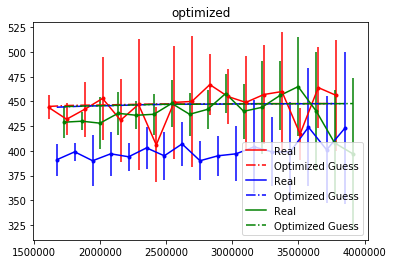

In [387]:
plt.figure()
plt.plot(freqs[0],split_vals_plot[0],label = 'Real', color = 'red')
plt.errorbar(freqs[0],split_vals_plot[0],yerr = e_split_vals_1, fmt=".r", capsize=0)
plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'Optimized Guess', color ='red', linestyle = '-.')

plt.plot(freqs[1],split_vals_plot[1],label = 'Real', color = 'blue')
plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'Optimized Guess', color ='blue', linestyle = '-.')
plt.errorbar(freqs[1],split_vals_plot[1],yerr = e_split_vals_2, fmt=".b", capsize=0)

plt.plot(freqs[2],split_vals_plot[2],label = 'Real', color = 'green')
plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'Optimized Guess', color ='green', linestyle = '-.')
plt.errorbar(freqs[2],split_vals_plot[2],yerr = e_split_vals_2, fmt=".g", capsize=0)
plt.title('optimized')
plt.legend(loc = 'best')
plt.show()




In [58]:
results.x

array([-25.80802319, -16.52019686, -10.42896148, 436.83602683,
       -20.70449762,  -6.9999999 ,  -4.99999987])

In [405]:
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 50
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

print("Running first burn-in...")
p0 = initial + 1e-5 * np.random.randn(nwalkers, ndim)
state = sampler.run_mcmc(p0, 5000)

Running first burn-in...


In [393]:
sampler.flatchain

array([[-8.23162999e+01, -6.45981723e+05, -4.21547231e+05, ...,
        -2.50529027e+05,  3.83178043e-01,  1.09709703e+00],
       [-8.23162972e+01, -6.45981723e+05, -4.21547231e+05, ...,
        -2.50529027e+05,  3.83208213e-01,  1.09711110e+00],
       [-8.23162882e+01, -6.45981723e+05, -4.21547231e+05, ...,
        -2.50529027e+05,  3.83225581e-01,  1.09710031e+00],
       ...,
       [-8.23162922e+01, -6.45981723e+05, -4.21547231e+05, ...,
        -2.50529027e+05,  3.83204170e-01,  1.09709188e+00],
       [-8.23163061e+01, -6.45981723e+05, -4.21547231e+05, ...,
        -2.50529027e+05,  3.83196817e-01,  1.09710144e+00],
       [-8.23162930e+01, -6.45981723e+05, -4.21547231e+05, ...,
        -2.50529027e+05,  3.83211095e-01,  1.09711654e+00]])

[-2.06787678e+02  6.06205922e+02  7.97812199e+02  1.25596785e+02
 -2.90311105e+04 -1.92665931e+04 -9.88058381e+00  8.46827184e+00]
[445.03300593 445.61841985 446.04370966 446.39502201 446.74620468
 447.02788385 447.28487684 447.50076418 447.67246646 447.84605316
 447.99540792 448.12806746 448.25299974 448.35585666 448.45561952
 448.54639714 448.62673074 443.85699158 444.56208532 445.17154317
 445.63927842 446.08789082 446.48684691 446.78876717 447.06509372
 447.29809988 447.50649941 447.70755974 447.87219016 448.02408789
 448.161177   448.27938396 448.39394561 448.49285612 444.15837061
 444.77020894 445.29206052 445.76906766 446.15817971 446.52504851
 446.81297855 447.05042701 447.28626681 447.4850991  447.6702829
 447.83853369 447.97870726 448.11582644 448.23689959 448.34670931
 448.45125958]
[-1.24683046e+06 -1.85786958e+06  3.84247271e+06 -1.95806708e+06
 -2.33126396e+07 -1.66031920e+07 -8.65631051e+00 -3.06296959e+00]
[444.71686891 445.30969788 445.73413884 446.08201964 446.4341552

[445.12074562 445.53383249 447.145471   446.59066833 446.60495901
 447.89365411 447.63939514 447.4979535  448.21692198 447.76154742
 447.65039127 448.3949946  447.92065832 447.84620858 448.43189496
 447.85806109 447.99480884 445.17719805 444.94238008 445.3215051
 446.60892619 446.29908336 446.75345523 447.76703835 447.24719502
 447.21911861 447.97823574 447.52911126 447.62404182 448.24856766
 447.66059516 447.82732444 448.30775201 447.70252443 444.84591276
 446.19835145 445.42920546 446.20882975 447.26414964 446.8683841
 447.30342152 447.85825562 447.22926125 447.55610502 448.13660833
 447.55343814 447.85015936 448.23502021 447.62196836 448.05160259
 448.26390029]
[-9.53146227e+00 -5.91079447e+03 -3.93291298e+03  4.44498141e+02
 -9.56081573e+03 -3.23803427e+04  9.13401562e+00 -1.86606513e+00]
[444.79253748 445.18570346 446.18326595 446.20424886 446.28013698
 447.0567111  447.1687174  447.09862096 447.54740448 447.5141154
 447.41734715 447.87755492 447.79607078 447.68701109 448.07815545

[445.24099858 445.16934677 446.65294787 445.9863337  446.76189954
 447.26264462 447.01861505 447.9762466  447.14893305 447.7498822
 447.69874608 447.52286853 448.13898217 447.46891311 448.09080121
 447.71097239 447.86479677 444.3100931  444.68214905 445.0867088
 446.04145231 445.65206949 447.08592046 446.74087768 447.04392921
 447.40426361 446.87965703 447.80188143 447.2459743  447.70151487
 447.69921401 447.45889801 448.00264052 447.47319525 444.07688155
 445.59198649 444.92949596 446.20523933 446.28143911 446.61526048
 447.40674636 446.63832975 447.50901408 447.15073102 447.37304921
 447.77396455 447.24610707 447.94025049 447.42721282 447.81894412
 447.78681754]
[ 1.49986277e+01  9.00602146e+03  7.40436879e+03  4.48828480e+02
 -7.82215696e+03 -7.17368050e+03  1.27214362e+01 -5.54489903e+00]
[445.35855076 445.35965996 446.66534635 446.02652191 447.14199965
 446.92978606 447.73338317 447.57466923 447.69193521 447.67027129
 447.80406471 447.86288142 447.92942641 447.95843512 447.8867199

[445.06117248 445.40910892 446.01763239 446.34224452 446.42843504
 447.12346931 447.11572257 447.44064865 447.52461266 447.44226681
 447.82751772 447.67362613 447.92150956 447.94564083 447.87610854
 448.13436416 447.95458904 443.71127458 444.77628319 444.91820938
 445.69752013 445.9389172  446.45092719 446.9006911  446.80858575
 447.22963294 447.18369593 447.40532737 447.6440383  447.52729023
 447.85239978 447.72872761 447.88855702 447.99635859 443.99314833
 445.00010264 445.25073559 445.6350158  446.33301546 446.42218605
 446.94085033 446.93558785 447.03901929 447.39610169 447.28409207
 447.64756136 447.59940515 447.6641735  447.88420739 447.74226842
 448.02121515]
[-1.23490851e+14  1.21156721e+16  1.23568065e+16 -1.93978976e+14
 -6.43117457e+15 -4.08865441e+16  8.73087892e-01  8.79852941e+00]
[445.10419958 445.69083994 446.11236403 446.46190276 446.81228091
 447.09332793 447.35116531 447.56490588 447.73613277 447.90875152
 448.05846095 448.18995786 448.31544539 448.41790687 448.51755

[444.84421848 445.57664927 445.96910189 446.26531367 446.69855224
 446.89075523 447.26331316 447.38010218 447.58538852 447.71380468
 447.85727334 448.00593781 448.08007241 448.22703342 448.24830783
 448.39889289 448.40899626 443.82854115 444.43129219 445.1686438
 445.49066025 446.04212154 446.41311582 446.71124491 447.00738803
 447.15371199 447.42333574 447.54476469 447.76878078 447.85450407
 448.0157583  448.10704079 448.20568326 448.32682349 444.17504306
 444.6818013  445.22629018 445.71603096 446.05344219 446.52482196
 446.70596464 447.0013311  447.15811629 447.38258235 447.55224622
 447.69602012 447.85960563 447.92952291 448.10631621 448.13921015
 448.29791429]
[ 6.81889936e+01  5.16469755e+02  5.83868573e+02  5.56295146e+02
 -1.32741603e+04 -5.35854403e+04  9.40947229e+00  8.43776194e+00]
[445.01785287 445.62045685 446.04551003 446.39082797 446.74475357
 447.029633   447.29074901 447.50429321 447.66748966 447.83797132
 447.98477127 448.11528587 448.2389711  448.33700003 448.434021

[444.91557201 445.49223373 445.91580521 446.26834739 446.61796627
 446.89672178 447.15121296 447.36783284 447.54259535 447.71774492
 447.86786736 448.00107963 448.12669107 448.23124413 448.33227635
 448.42404802 448.5054109  443.73539631 444.43531546 445.04420509
 445.51284079 445.95887783 446.35416079 446.65555952 446.93357821
 447.16921646 447.37900248 447.58017128 447.74565967 447.89866941
 448.03715046 448.15678618 448.27206199 448.37192621 444.03370513
 444.64314659 445.16572201 445.64174149 446.02802276 446.39175455
 446.68019657 446.92048524 447.15802839 447.35783754 447.54337697
 447.71231028 447.85413718 447.99247531 448.11466586 448.22543255
 448.33062509]
[-3.43368346e+06  2.30770669e+07  3.45464302e+07 -5.39316794e+06
 -8.56368878e+07 -9.93457257e+07  1.47700121e+01  7.50776123e-01]
[444.53933744 445.12989814 445.55445726 445.90318746 446.25490379
 446.53720688 446.79526471 447.0100876  447.17860975 447.35096898
 447.49924448 447.63097953 447.75536565 447.85640482 447.95512

[-1.76069302e+01 -1.89952278e+02 -1.25415250e+02  4.41115342e+02
 -1.53266703e+04 -3.92269593e+04 -9.86999609e+00 -9.95366561e+00]
[445.82190468 446.0597741  447.14059952 447.26077967 447.12362349
 447.93389951 448.27667583 447.98781012 448.30934144 448.45440155
 448.15133997 448.54767245 448.65499396 448.31862358 448.65997528
 448.64818482 448.41908519 445.18500947 445.6434662  445.7361274
 446.66806864 447.00693691 447.14207143 447.83721119 447.94120644
 447.64390027 448.127114   448.26737347 448.03511623 448.4620001
 448.43949376 448.21595805 448.61151698 448.51043321 445.05223109
 446.31500765 446.19110127 446.45557029 447.41571944 447.58107203
 447.55632796 448.04036737 447.98040201 447.85243339 448.38251623
 448.31896423 448.14714429 448.56271897 448.41083761 448.33450385
 448.68775609]
[ 2.23241698e+01 -9.93980790e+02 -2.06426144e+03  4.14887190e+02
 -2.25116345e+04 -1.41684068e+05  3.17081270e+00 -8.57248812e+00]
[445.25422267 445.84729884 446.27240489 446.6210351  446.97356
 4

[445.20123601 445.70210763 446.52084002 446.3567443  447.00088839
 447.24570593 447.62587174 447.85726725 447.60972102 447.90232352
 447.7529614  448.05135115 447.90969438 448.10708588 447.88565857
 448.15976708 447.9040769  443.79443452 445.2135788  445.21878152
 446.0779485  446.04442777 447.20653209 446.89493803 447.55839413
 447.14419088 447.61686965 447.48248754 447.84272427 447.65494391
 447.93382535 447.72516242 447.98248309 447.85304091 444.26755215
 445.53732531 445.31699166 446.29188113 446.35201344 447.15594
 447.19859043 447.24920125 447.40952658 447.42872157 447.67341921
 447.66864732 447.80558565 447.70931712 447.9207719  447.75921192
 448.02240949]
[-1.16380019e+04  1.38444087e+05  1.41967453e+05 -1.78303085e+04
 -4.04032351e+05 -1.96338480e+05 -7.95319782e+00 -5.33181556e+00]
[445.02368433 445.57264612 445.98880534 446.34329321 446.68723561
 446.95656899 447.20296203 447.42143884 447.60553398 447.78579872
 447.93871286 448.07400002 448.20202809 448.31212726 448.41745109

[444.65165821 445.24421792 445.66866725 446.01663884 446.36871344
 446.65127504 446.90978617 447.1243488  447.29183674 447.4638825
 447.61184003 447.74329792 447.86756974 447.96801096 448.06643145
 448.15605993 448.23486471 443.48354409 444.19027015 444.79883224
 445.26313691 445.71282418 446.11430396 446.41485708 446.68908054
 446.91870332 447.1248356  447.3256572  447.48850914 447.63895118
 447.77444849 447.89054638 448.00440833 448.10189377 443.79014468
 444.40061408 444.9196382  445.39619267 445.78567791 446.154648
 446.44082548 446.67423764 446.90821357 447.10503542 447.28924474
 447.45649991 447.59412821 447.72991837 447.84940917 447.95773617
 448.06156244]
[-2.94856285e+00  9.25075380e+03  5.77534096e+03  4.50959375e+02
 -5.01072096e+03 -8.27965418e+04 -2.00981056e-01 -1.13177064e+00]
[444.3913519  444.94007102 445.54375524 445.80987296 446.07548229
 446.50781499 446.72574987 446.83720789 447.14087721 447.3589261
 447.40624868 447.59419467 447.79297266 447.8242327  447.93224944


[ 4.57948842e+00  2.07651748e+04  1.46083260e+04  4.47830199e+02
 -5.16210199e+04 -4.71786352e+04 -3.88140589e+00  9.12013990e-01]
[444.86491346 445.92879073 446.10654263 446.38340968 446.9782072
 447.00518967 447.42155555 447.68402368 447.5859389  447.94053296
 447.99063941 448.02488339 448.31916932 448.21908397 448.36045422
 448.50320171 448.40886289 443.93009459 444.61471607 445.48051203
 445.60615195 446.20451895 446.73551215 446.78784315 447.23901156
 447.36825777 447.42699713 447.82635486 447.80679923 447.96461075
 448.18671037 448.10199736 448.3415211  448.3920301  444.54554472
 444.80729154 445.45824503 446.00759712 446.16074658 446.79506461
 446.98589465 447.04331439 447.46745705 447.47127054 447.66304983
 447.94197599 447.86105153 448.10872154 448.20027789 448.17738511
 448.42962094]
[-3.06285750e+15  6.87475150e+15  1.67880560e+16 -4.81112531e+15
 -7.36244205e+16 -3.56950657e+16 -6.15936073e+00  8.43685350e+00]
[444.32740664 444.91931695 445.34352824 445.69139945 446.0432004

[-3.26599746e+00 -5.38893707e+02 -3.56305291e+02  4.47525942e+02
 -1.54710436e+04 -3.89792652e+04 -9.14741875e+00  8.36820877e+00]
[444.60732885 445.10855935 445.69233137 445.98609518 446.22211846
 446.63811314 446.90196055 446.99857614 447.22787046 447.38565055
 447.42640199 447.63974747 447.7495795  447.74867699 447.92435529
 447.98010664 447.98664279 443.55470519 444.19321963 444.68874874
 445.27681313 445.68639034 446.02115891 446.42965755 446.65566273
 446.76908518 447.0605488  447.23351541 447.30665602 447.54107294
 447.6288427  447.66923739 447.86653802 447.90557291 443.7485295
 444.51169622 444.87956829 445.31490092 445.84232017 446.14506098
 446.36866451 446.6803551  446.83380156 446.96415332 447.24365394
 447.34255517 447.41813208 447.63516407 447.67784771 447.75117122
 447.92753596]
[-1.64842130e+04  2.30146958e+04  7.83883890e+04 -2.54437171e+04
 -4.75681787e+05 -2.53436518e+05  1.11887341e+01  9.89258842e+00]
[444.67699438 445.26885264 445.69349625 446.0419201  446.3939299

[446.11782521 446.34807925 446.53204835 446.96787349 447.68458375
 448.10716275 448.2453622  448.13422171 447.9873375  448.1817406
 448.49695442 448.73837993 448.80184814 448.63792641 448.55638026
 448.6411771  448.82186687 445.38500952 446.17871788 446.50858823
 446.45738714 446.68232652 447.2095476  447.69548203 448.10414127
 448.19637727 448.10153824 448.09948658 448.19367312 448.46442437
 448.71598733 448.76410515 448.71303626 448.61795746 445.31602246
 446.08754229 446.80661932 447.32542239 447.46400047 447.55252854
 447.59162194 447.75722536 448.1545696  448.43687269 448.54862277
 448.49796001 448.37999985 448.46638303 448.66811033 448.86346184
 448.95503152]
[-7.05319476e+00 -1.03864133e+02 -1.29825542e+02  4.60561579e+02
 -1.54020111e+04 -3.92538903e+04 -9.65318326e+00 -3.01916214e+00]
[444.97001831 445.56486093 445.98961118 446.33721779 446.68985858
 446.97298725 447.23214239 447.44662728 447.61335115 447.78520768
 447.93301745 448.06435829 448.18860029 448.28861563 448.386828

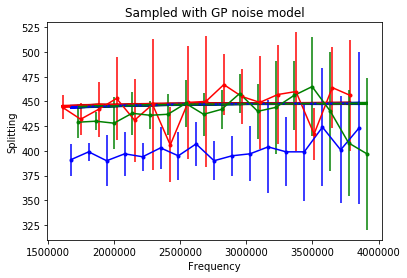

Text(0, 0.5, 'log_L_1_1')

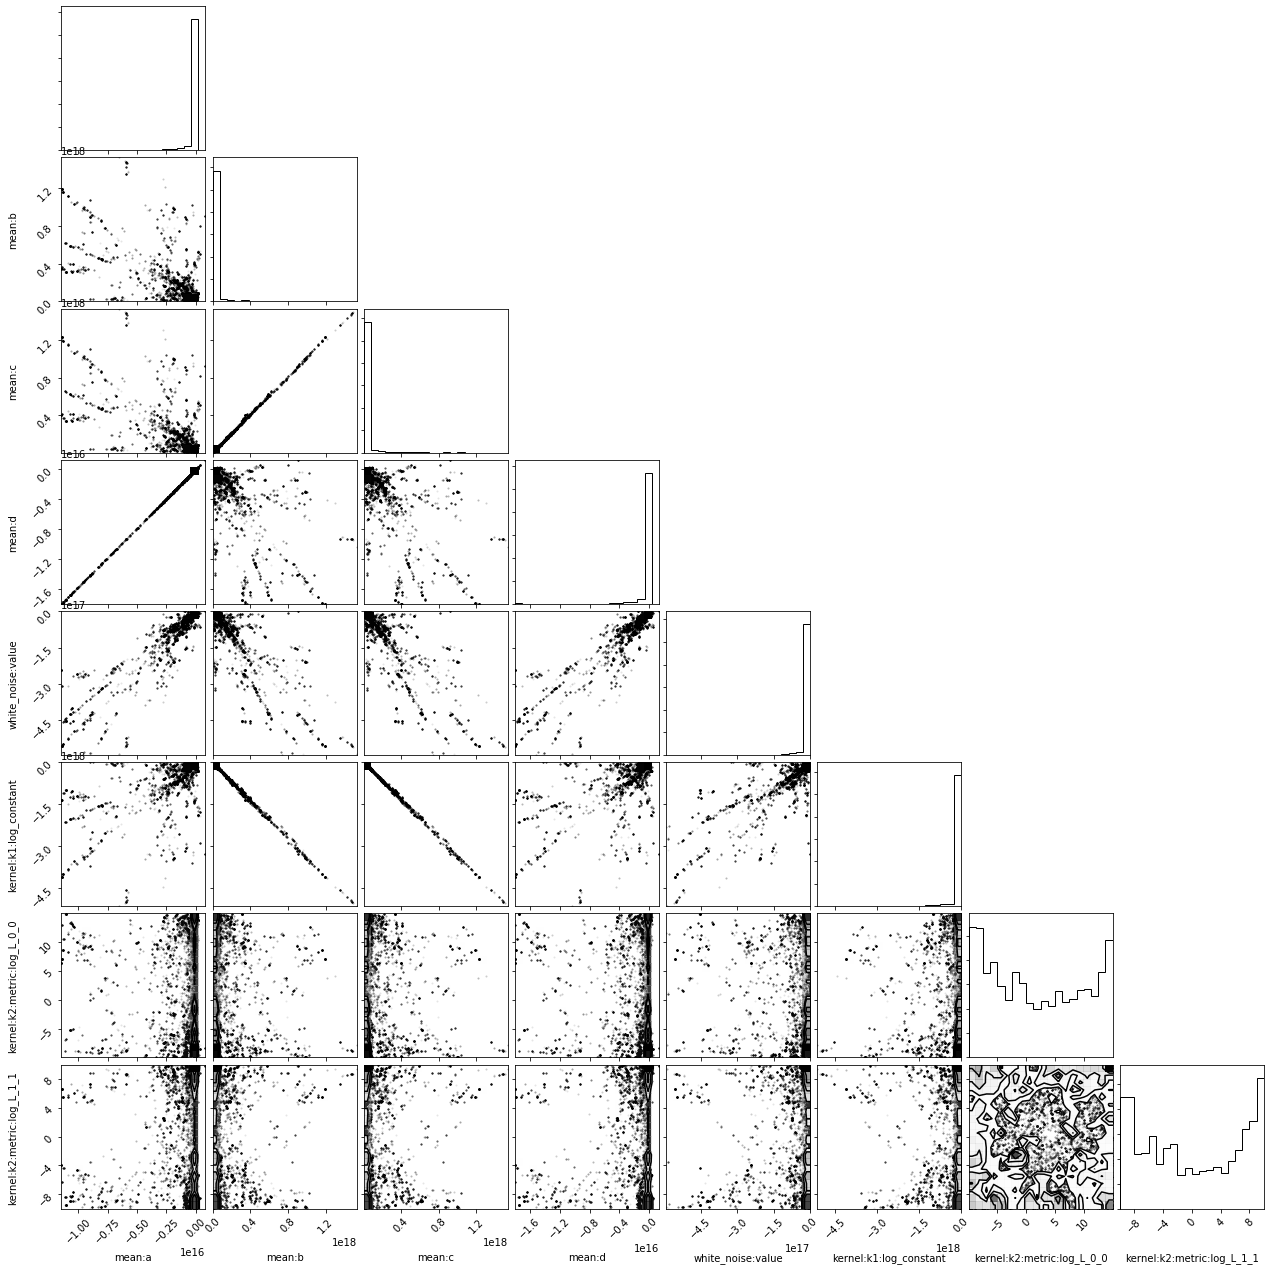

<Figure size 432x288 with 0 Axes>

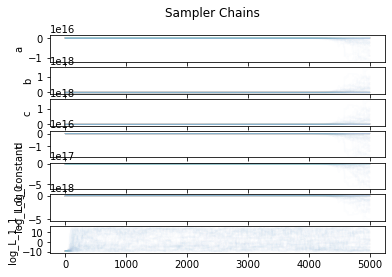

In [406]:
# Plot the data
#plt.errorbar(freqs_1, split_vals_1, yerr=e_split_vals_1, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
# ARC says: not sure what this was meant for...

x = np.linspace(1000, 3000, 5000)


# Plot 24 posterior samples.
plt.figure()
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=200)]:
    print(s)
    gp.set_parameter_vector(s)
    m = gp.sample_conditional(split_vals, xvals)
    print(m)
    plt.plot(freqs[0], m[0:17], color="red", alpha=0.1)
    plt.plot(freqs[1], m[17:34], color="blue", alpha=0.1)
    plt.plot(freqs[2], m[34:51], color="green", alpha=0.1)


plt.plot(freqs[0],split_vals_plot[0],label = 'Real', color = 'red')
plt.errorbar(freqs[0],split_vals_plot[0],yerr = e_split_vals_1, fmt=".r", capsize=0)
plt.plot(freqs[0],mean_model.get_value_plot(None)[0], label = 'Optimized Guess', color ='red', linestyle = '-.')

plt.plot(freqs[1],split_vals_plot[1],label = 'Real', color = 'blue')
plt.plot(freqs[1],mean_model.get_value_plot(None)[1], label = 'Optimized Guess', color ='blue', linestyle = '-.')
plt.errorbar(freqs[1],split_vals_plot[1],yerr = e_split_vals_2, fmt=".b", capsize=0)

plt.plot(freqs[2],split_vals_plot[2],label = 'Real', color = 'green')
plt.plot(freqs[2],mean_model.get_value_plot(None)[2], label = 'Optimized Guess', color ='green', linestyle = '-.')
plt.errorbar(freqs[2],split_vals_plot[2],yerr = e_split_vals_2, fmt=".g", capsize=0)


plt.ylabel("Splitting")
plt.xlabel("Frequency")
#plt.xlim(-5, 5)
plt.title("Sampled with GP noise model");
#
plt.show()

names = gp.get_parameter_names()
inds = np.array([names.index(k) for k in names])
corner.corner(sampler.chain[:, 2500:, :].reshape((-1, 8)), labels=names)

#names = gp.get_parameter_names()
#corner.corner(sampler.chain.reshape((-1, 3)), labels=names)

plt.figure()
fig, axs = plt.subplots(7)
fig.suptitle('Sampler Chains')
for i in range(50): axs[0].plot(sampler.chain[i,:,0],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[1].plot(sampler.chain[i,:,1],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[2].plot(sampler.chain[i,:,2],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[3].plot(sampler.chain[i,:,3],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[4].plot(sampler.chain[i,:,4],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[5].plot(sampler.chain[i,:,5],color = 'tab:blue', alpha = 0.01)
for i in range(50): axs[6].plot(sampler.chain[i,:,6],color = 'tab:blue', alpha = 0.01)

axs[0].set_ylabel('a')
axs[1].set_ylabel('b')
axs[2].set_ylabel('c')
axs[3].set_ylabel('d')
axs[4].set_ylabel('Log_constant')
axs[5].set_ylabel('log_L_0_0')
axs[6].set_ylabel('log_L_1_1')

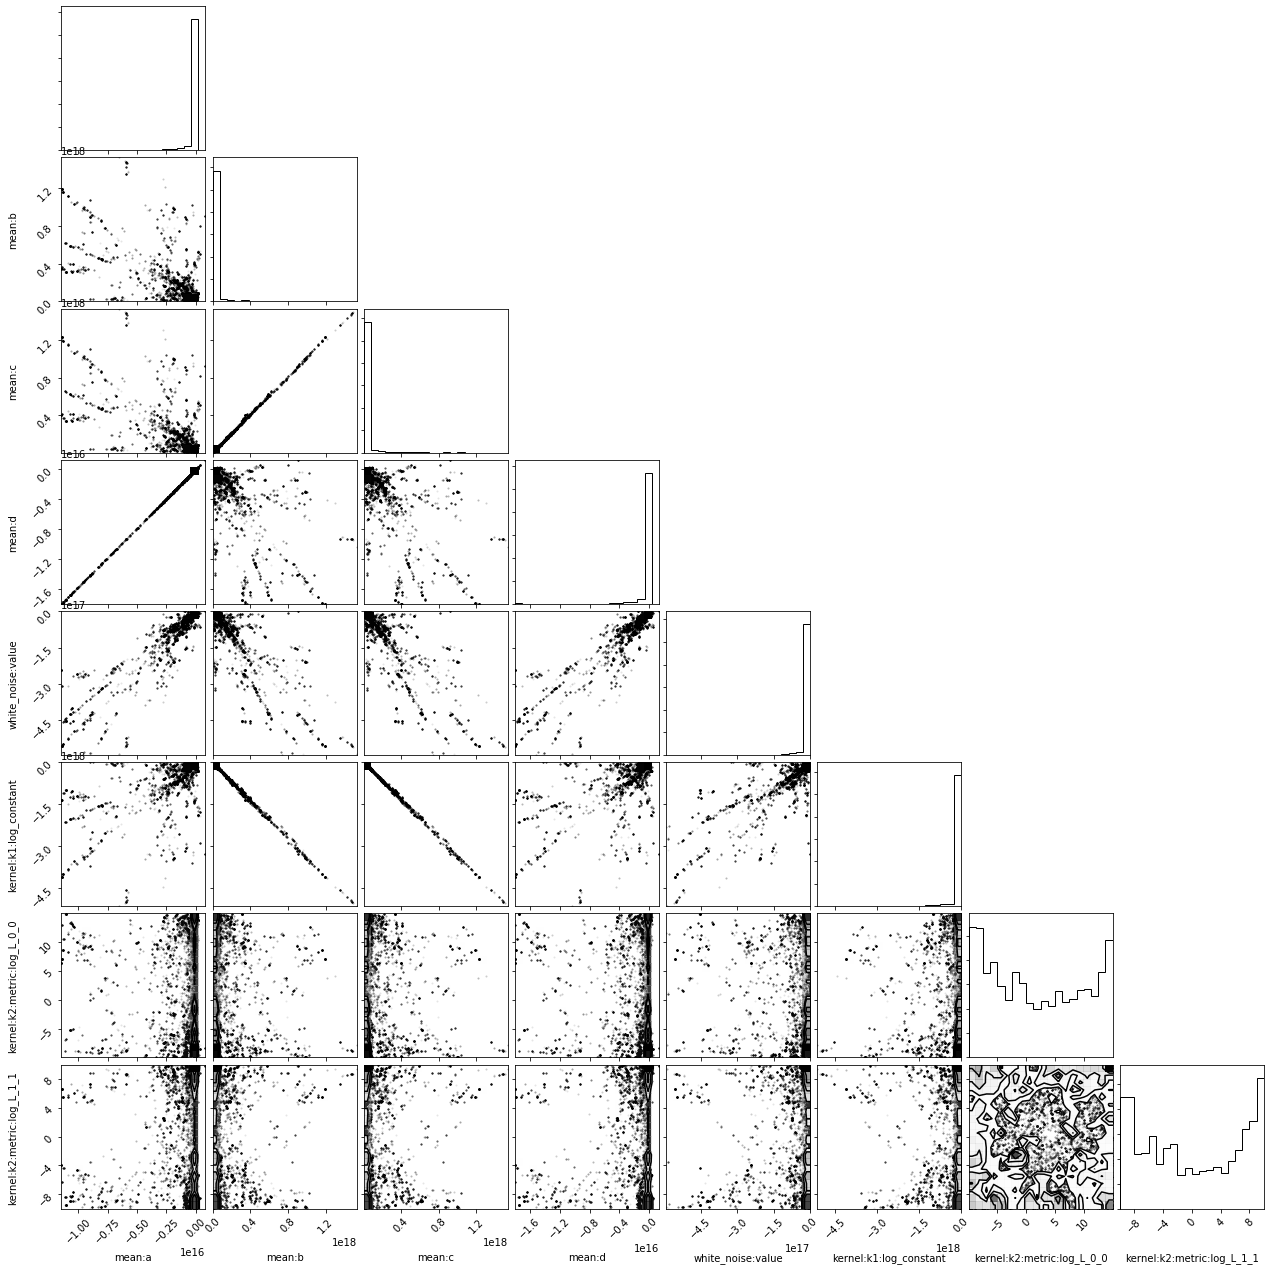

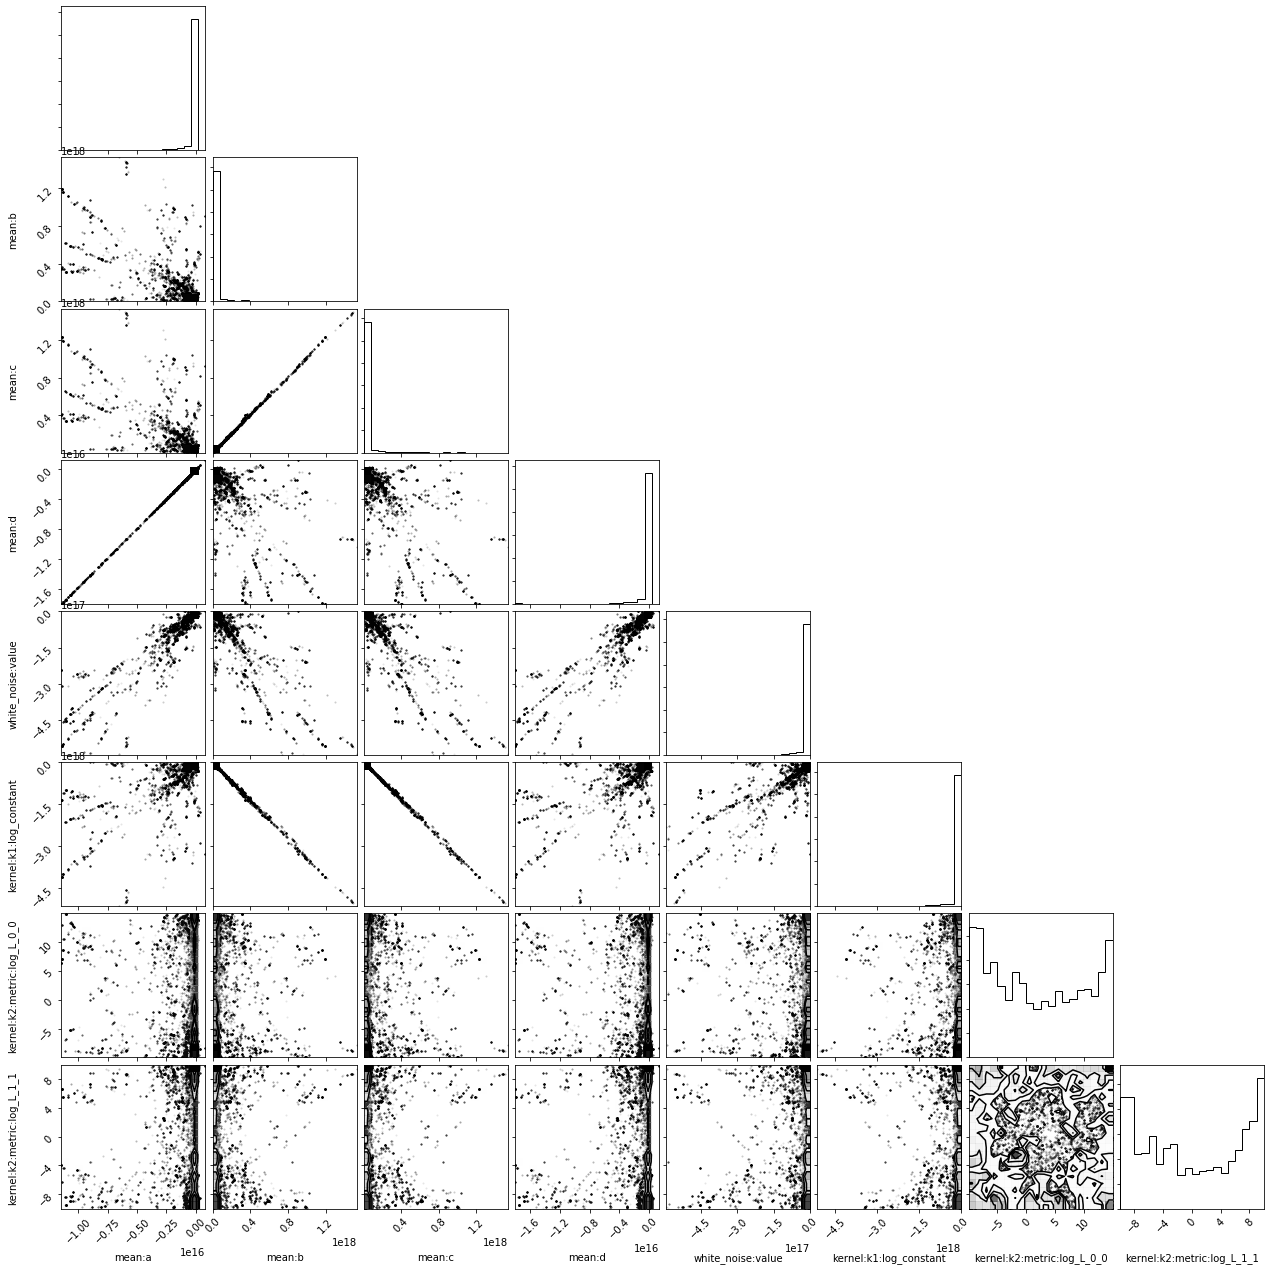

In [407]:
names = gp.get_parameter_names()
inds = np.array([names.index(k) for k in names])
corner.corner(sampler.chain[:, 2500:, :].reshape((-1, 8)), labels=names)